In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
sp = pd.read_csv('../data/sp1950.csv')
#sp['Date'] = pd.to_datetime(sp.Date)
sp = sp[['Date', 'Open', 'Close', 'Adj Close']]
sp = sp.rename(columns={'Adj Close': 'Value'})
sp.head()

,Date,Open,Close,Value
0,1/3/50,16.66,16.66,16.66
1,1/4/50,16.85,16.85,16.85
2,1/5/50,16.93,16.93,16.93
3,1/6/50,16.98,16.98,16.98
4,1/9/50,17.08,17.08,17.08


In [3]:
sp.tail()

,Date,Open,Close,Value
17378,1/28/19,2657.439941,2643.85,2643.85
17379,1/29/19,2657.439941,2640.00,2640.00
17380,1/30/19,2657.439941,2681.05,2681.05
17381,1/31/19,2657.439941,2704.10,2704.10
17382,2/1/19,2657.439941,2706.53,2706.53


In [4]:
def date2datetime(date):
    month, day, year = date.split('/')
    if int(year) > 20:
        year = int(year) + 1900
    else:
        year = int(year) + 2000
    try:
        return pd.to_datetime(f'{year}-{month}-{day}')
    except:
        print(date)

In [5]:
date2datetime('1/3/50')

Timestamp('1950-01-03 00:00:00')

In [6]:
sp.Date = sp.Date.apply(date2datetime)
sp.head()

,Date,Open,Close,Value
0,1950-01-03,16.66,16.66,16.66
1,1950-01-04,16.85,16.85,16.85
2,1950-01-05,16.93,16.93,16.93
3,1950-01-06,16.98,16.98,16.98
4,1950-01-09,17.08,17.08,17.08


In [7]:
sp['ChangeSinceOpen'] = sp['Close'] / sp['Open']
sp.tail()

,Date,Open,Close,Value,ChangeSinceOpen
17378,2019-01-28,2657.439941,2643.85,2643.85,0.994886
17379,2019-01-29,2657.439941,2640.00,2640.00,0.993437
17380,2019-01-30,2657.439941,2681.05,2681.05,1.008885
17381,2019-01-31,2657.439941,2704.10,2704.10,1.017558
17382,2019-02-01,2657.439941,2706.53,2706.53,1.018473


In [8]:
sp['DailyChange'] = np.nan
sp['OvernightChange'] = np.nan
for day in range(1, sp.shape[0]):
    sp.loc[day, 'DailyChange'] = (sp.loc[day, 'Value'] 
                                  / sp.loc[day - 1, 'Value'])
    sp.loc[day, 'OvernightChange'] = (sp.loc[day, 'Open'] 
                                      / sp.loc[day - 1, 'Close'])
    #if day < 3000 and sp.loc[day, 'ChangeSinceOpen'] == 1.:
    #    sp.loc[day, 'ChangeSinceOpen'] = sp.loc[day, 'DailyChange']
sp.tail()        

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange
17378,2019-01-28,2657.439941,2643.85,2643.85,0.994886,0.992153,0.997253
17379,2019-01-29,2657.439941,2640.00,2640.00,0.993437,0.998544,1.005140
17380,2019-01-30,2657.439941,2681.05,2681.05,1.008885,1.015549,1.006606
17381,2019-01-31,2657.439941,2704.10,2704.10,1.017558,1.008597,0.991194
17382,2019-02-01,2657.439941,2706.53,2706.53,1.018473,1.000899,0.982745


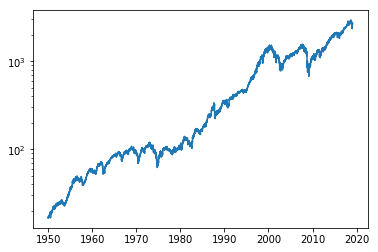

In [9]:
plt.plot(sp.Date, sp.Value);
plt.yscale('log');

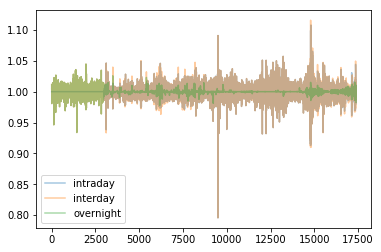

In [10]:
plt.plot(sp.ChangeSinceOpen, alpha=0.4, label='intraday')
plt.plot(sp.DailyChange, alpha=0.4, label='interday')
plt.plot(sp.OvernightChange, alpha=0.4, label='overnight')
plt.legend();

In [11]:
#list(sp['ChangeSinceOpen'] > 1.).index(True) # 3014
#(sp['ChangeSinceOpen'][:3013] == 1).all() # True
#(sp['ChangeSinceOpen'][:3014] == 1).all() # False
sp = sp.loc[3014:, :]
sp.index = range(sp.shape[0])

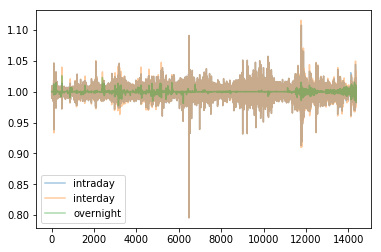

In [12]:
plt.plot(sp.ChangeSinceOpen, alpha=0.4, label='intraday')
plt.plot(sp.DailyChange, alpha=0.4, label='interday')
plt.plot(sp.OvernightChange, alpha=0.4, label='overnight')
plt.legend();

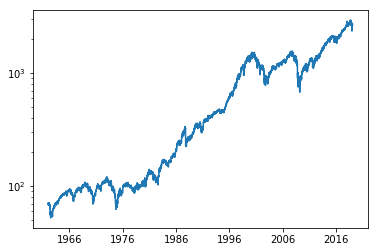

In [13]:
plt.plot(sp.Date, sp.Value);
plt.yscale('log');

In [14]:
def moving_dev_signals(x, params):
    '''
    @params
    x: list: time series of prices
    params: list: [up_qs, up_amounts, down_qs, down_amounts]
    up_qs, down_qs: lists: quantiles for which, moving upward/downward 
        across signals an action
    up_amounts, down_amounts: lists: amount to put in (+) or take out (-)
        associated with each up signal (qs)
    @return: array of signals (usually just one, but multiple events may
        occur on a single day)
    '''
    up_qs, up_amounts, down_qs, down_amounts = params
    x = x.tolist()
    n = len(x)
    up_qs = np.quantile(x, up_qs)
    down_qs = np.quantile(x, down_qs)
    signals = []
    for q, action in zip(up_qs, up_amounts):
        if x[n - 2] < q and x[n - 1] > q:
            signals.append(action)
    for q, action in zip(down_qs, down_amounts):
        if x[n - 2] > q and x[n - 1] < 1:
            signals.append(action)
    return signals if signals else [0]

In [15]:
def sliding_window(x, window, func, **kwargs):
    '''
    Apply the function func to each frame of a timeseries, x with a moving
    window, window
    
    @params
    x: list: the complete time series of prices
    window: int: the number of days to apply the function to
    func: function: a function that takes a time series as input and 
        returns a list of one or more signals each day, where a signal is
        the percentage of money to put in or take out
    **kwargs: additional arguments to pass to func
    @return: a list of lists, each list in the primary list is a list of 
        signals for each single day
    '''
    n = len(x)
    all_signals = [[0] for _ in range(window)]
    for w in range(window, n):
        signals = func(x[(w - window):w], **kwargs)
        all_signals.append(signals)
    return all_signals

In [16]:
# Test 
x = sp.Value
up_qs = [0.05, 0.45]
up_amounts = [0.9, 0.3]
down_qs = [0.95, 0.55]
down_amounts = [-0.7, -0.9]
params = [up_qs, up_amounts, down_qs, down_amounts]
window = 30

#actions = sliding_window(x, 
#                         window, 
#                         moving_dev_signals,
#                         up_qs=up_qs, 
#                         up_amounts=up_amounts, 
#                         down_qs=down_qs,
#                         down_amounts=down_amounts)
# The action based on today gets applied tomorrow
#actions = [0] + actions[:-1] 

In [17]:
def generate_actions(sp, window, func, params):
    x = sp.Value
    actions = sliding_window(x, window, func, params=params)
    actions = [0] + actions[:-1]
    sp['Actions'] = actions
    return sp

In [18]:
sp = generate_actions(sp, 30, moving_dev_signals, params=params)
sp.tail()

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange,Actions
14364,2019-01-28,2657.439941,2643.85,2643.85,0.994886,0.992153,0.997253,[0]
14365,2019-01-29,2657.439941,2640.00,2640.00,0.993437,0.998544,1.005140,[0]
14366,2019-01-30,2657.439941,2681.05,2681.05,1.008885,1.015549,1.006606,[0]
14367,2019-01-31,2657.439941,2704.10,2704.10,1.017558,1.008597,0.991194,[0]
14368,2019-02-01,2657.439941,2706.53,2706.53,1.018473,1.000899,0.982745,[0]


In [19]:
init_amount = sp.Value[0]
init_amount

71.129997

In [20]:
sp['Reserve'] = np.nan
sp['Invested'] = np.nan
sp.loc[0, 'Reserve'] = init_amount
sp.loc[0, 'Invested'] = 0.
sp.head()

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange,Actions,Reserve,Invested
0,1962-01-03,70.959999,71.129997,71.129997,1.002396,1.002396,1.0,0,71.129997,0.0
1,1962-01-04,71.129997,70.639999,70.639999,0.993111,0.993111,1.0,[0],NaN,NaN
2,1962-01-05,70.639999,69.660004,69.660004,0.986127,0.986127,1.0,[0],NaN,NaN
3,1962-01-08,69.660004,69.120003,69.120003,0.992248,0.992248,1.0,[0],NaN,NaN
4,1962-01-09,69.120003,69.150002,69.150002,1.000434,1.000434,1.0,[0],NaN,NaN


In [21]:
def update_values(row):
    reserve = row['Reserve']
    invested = row['Invested']
    change_since_open = row['ChangeSinceOpen']
    overnight_change = row['OvernightChange']
    invested *= overnight_change
    money_per_action = 0
    for action in row['Actions']:
        if action > 0: # Buy
            money_per_action = reserve * action
        if action < 0: # Sell
            money_per_action = invested * action    
        reserve -= money_per_action
        invested += money_per_action
    invested *= change_since_open
    return reserve, invested

In [22]:
def predict_performance(sp):
    for day in range(1, sp.shape[0]):
        sp.loc[day, ['Reserve', 'Invested']] = sp.loc[
            day - 1, ['Reserve', 'Invested']]
        sp.loc[day, ['Reserve', 'Invested']] = update_values(
            sp.loc[day, :])
        sp['Total'] = sp['Reserve'] + sp['Invested']
    return sp

In [23]:
sp = predict_performance(sp)
sp.tail()

,Date,Open,Close,Value,ChangeSinceOpen,DailyChange,OvernightChange,Actions,Reserve,Invested,Total
14364,2019-01-28,2657.439941,2643.85,2643.85,0.994886,0.992153,0.997253,[0],0.0,2685.770871,2685.770871
14365,2019-01-29,2657.439941,2640.00,2640.00,0.993437,0.998544,1.005140,[0],0.0,2681.859826,2681.859826
14366,2019-01-30,2657.439941,2681.05,2681.05,1.008885,1.015549,1.006606,[0],0.0,2723.560714,2723.560714
14367,2019-01-31,2657.439941,2704.10,2704.10,1.017558,1.008597,0.991194,[0],0.0,2746.976195,2746.976195
14368,2019-02-01,2657.439941,2706.53,2706.53,1.018473,1.000899,0.982745,[0],0.0,2749.444725,2749.444725


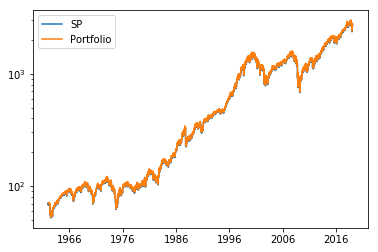

In [24]:
plt.plot(sp.Date, sp.Value, label='SP')
plt.plot(sp.Date, sp.Total, label='Portfolio');
plt.yscale('log');
plt.legend();

In [25]:
sp.Total.tolist()[-1]

2749.4447249211316

# Repeat Search from Here

### 3-Deviations per direction (private portfolio)

In [197]:
ITERS = 30
best_yet = 6363.96
best_params = [
    [0.7330538422628589, 0.7381918454222405, 0.1186431462318032], 
    [0.6052552218016803, 0.9696992288605488, -0.20708364487883854], 
    [0.7364474342299856, 0.2898195055191956, 0.32547783207354575], 
    [0.9247689190281905, 0.3965944286935519, -0.7579907476201633]]
best_window = 201
print(f'best yet: {best_yet}\nbest params:\n{best_params}\n'
      f'best window:{best_window}')
sd = 0.008

best yet: 6363.96
best params:
[[0.7330538422628589, 0.7381918454222405, 0.1186431462318032], [0.6052552218016803, 0.9696992288605488, -0.20708364487883854], [0.7364474342299856, 0.2898195055191956, 0.32547783207354575], [0.9247689190281905, 0.3965944286935519, -0.7579907476201633]]
best window:201


In [198]:
def init_values(sd, init_window, init_params, min_window=10):
    up_qs, up_amts, down_qs, down_amts = init_params
    def trunc_normal(mean, sd, minval, maxval):
        val = np.random.normal(mean, scale=sd)
        val = max(min(val, maxval), minval)
        return val
    
    window = int(round(trunc_normal(init_window, 400*sd, min_window, 500)))
    up_q1   = trunc_normal(up_qs[0], sd, 0.05, 0.95)
    up_q2   = trunc_normal(up_qs[1], sd, 0.05, 0.95)
    up_q3   = trunc_normal(up_qs[2], sd, 0.05, 0.95)
    down_q1 = trunc_normal(down_qs[0], sd, 0.05, 0.95)
    down_q2 = trunc_normal(down_qs[1], sd, 0.05, 0.95)
    down_q3 = trunc_normal(down_qs[2], sd, 0.05, 0.95)
    up_amount1   = trunc_normal(up_amts[0], 2*sd, -1, 1)
    up_amount2   = trunc_normal(up_amts[1], 2*sd, -1, 1)
    up_amount3   = trunc_normal(up_amts[2], 2*sd, -1, 1)
    down_amount1 = trunc_normal(down_amts[0], 2*sd, -1, 1)
    down_amount2 = trunc_normal(down_amts[1], 2*sd, -1, 1)
    down_amount3 = trunc_normal(down_amts[2], 2*sd, -1, 1)
    up_qs = [up_q1, up_q2, up_q3]
    down_qs = [down_q1, down_q2, down_q3]
    up_amounts = [up_amount1, up_amount2, up_amount3]
    down_amounts = [down_amount1, down_amount2, down_amount3]
    params = [up_qs, up_amounts, down_qs, down_amounts]
    return window, params

#init_values(sd, best_window, best_params)

 1: Final value: $ 5708.77 (window = 200)
 2: Final value: $ 6143.87 (window = 199)
 3: Final value: $ 5767.16 (window = 199)
 4: Final value: $ 6146.09 (window = 202)
 5: Final value: $ 6324.36 (window = 201)
 6: Final value: $ 5888.87 (window = 197)
 7: Final value: $ 5370.20 (window = 196)
 8: Final value: $ 5876.77 (window = 203)
 9: Final value: $ 5819.87 (window = 197)
10: Final value: $ 6026.65 (window = 197)
11: Final value: $ 6087.18 (window = 198)
12: Final value: $ 6246.19 (window = 201)
13: Final value: $ 5897.82 (window = 204)
14: Final value: $ 5870.61 (window = 203)
15: Final value: $ 6190.78 (window = 203)
16: Final value: $ 6027.58 (window = 200)
17: Final value: $ 5261.70 (window = 193)
18: Final value: $ 5906.68 (window = 199)
19: Final value: $ 6065.93 (window = 198)
20: Final value: $ 6180.94 (window = 201)
21: Final value: $ 6109.18 (window = 200)
22: Final value: $ 5831.28 (window = 199)
23: Final value: $ 5614.41 (window = 197)
24: Final value: $ 5868.57 (window

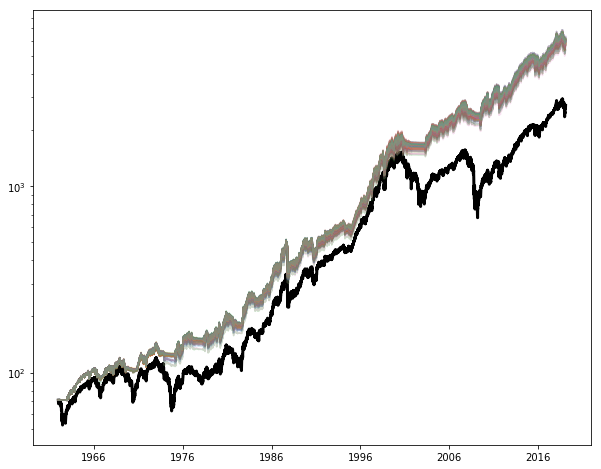

In [199]:
plt.figure(figsize=[10, 8])
plt.plot(sp.Date, sp.Value, 'k-', linewidth=3)
for i in range(ITERS):
    window, params = init_values(sd, best_window, best_params)
    sp = generate_actions(
        sp, window, func=moving_dev_signals, params=params)
    sp = predict_performance(sp)
    plt.plot(sp.Date, sp.Total, alpha=0.2);
    final_value = sp.Total.tolist()[-1]
    print(f'{i + 1:2d}: Final value: ${final_value:8.2f} '
          f'(window = {window})')
    if final_value > best_yet:
        print(f'New best model!\n{params}\nwindow: {window}')
        best_yet = final_value
        best_params = params
plt.yscale('log');    

### 2-Deviations per direction (401(k))

In [203]:
best_yet_401k = 4770.95
best_params_401k = [
    [0.05, 0.7433841170484274], [-0.43402238015840733, 1], 
    [0.8433100187872895, 0.11219277180793466], [1, 1]]
best_window_401k = 213
print(f'best yet: {best_yet_401k}\nbest params:\n{best_params_401k}\n'
      f'best window:{best_window_401k}')
sd = 0.512

best yet: 3520.12
best params:
[[0.05, 0.8448340410862901], [1, 1], [0.8057746361569654, 0.40796668140260106], [-0.23922210137911457, 0.26343372471254056]]
best window:127


In [204]:
def init_values(sd, init_window, init_params, min_window=60):
    up_qs, up_amts, down_qs, down_amts = init_params
    def trunc_normal(mean, sd, minval, maxval):
        val = np.random.normal(mean, scale=sd)
        val = max(min(val, maxval), minval)
        return val
    
    window = int(round(trunc_normal(init_window, 400*sd, min_window, 500)))
    up_q1   = trunc_normal(up_qs[0], sd, 0.05, 0.95)
    up_q2   = trunc_normal(up_qs[1], sd, 0.05, 0.95)
    down_q1 = trunc_normal(down_qs[0], sd, 0.05, 0.95)
    down_q2 = trunc_normal(down_qs[1], sd, 0.05, 0.95)
    up_amount1   = trunc_normal(up_amts[0], 2*sd, -1, 1)
    up_amount2   = trunc_normal(up_amts[1], 2*sd, -1, 1)
    down_amount1 = trunc_normal(down_amts[0], 2*sd, -1, 1)
    down_amount2 = trunc_normal(down_amts[1], 2*sd, -1, 1)
    up_qs = [up_q1, up_q2]
    down_qs = [down_q1, down_q2]
    up_amounts = [up_amount1, up_amount2]
    down_amounts = [down_amount1, down_amount2]
    params = [up_qs, up_amounts, down_qs, down_amounts]
    return window, params

#init_values(sd, best_window, best_params)

 1: Final value: $ 1569.75 (window = 500)
 2: Final value: $ 2906.33 (window = 60)
 3: Final value: $ 2618.55 (window = 462)
 4: Final value: $ 3237.54 (window = 127)
 5: Final value: $ 1848.10 (window = 70)
 6: Final value: $ 3334.76 (window = 60)
 7: Final value: $ 2642.72 (window = 379)
 8: Final value: $   71.13 (window = 238)
 9: Final value: $ 2295.07 (window = 500)
10: Final value: $ 2909.41 (window = 241)
11: Final value: $ 2260.03 (window = 500)
12: Final value: $ 2809.62 (window = 254)
13: Final value: $ 2030.38 (window = 353)
14: Final value: $ 2381.40 (window = 60)
15: Final value: $ 2905.75 (window = 262)
16: Final value: $ 2906.33 (window = 60)
17: Final value: $ 2809.21 (window = 75)
18: Final value: $ 1183.58 (window = 187)
19: Final value: $ 2260.63 (window = 390)
20: Final value: $ 2749.83 (window = 60)
21: Final value: $ 2906.33 (window = 60)
22: Final value: $ 2837.37 (window = 248)
23: Final value: $ 2664.57 (window = 455)
24: Final value: $ 2382.32 (window = 500)


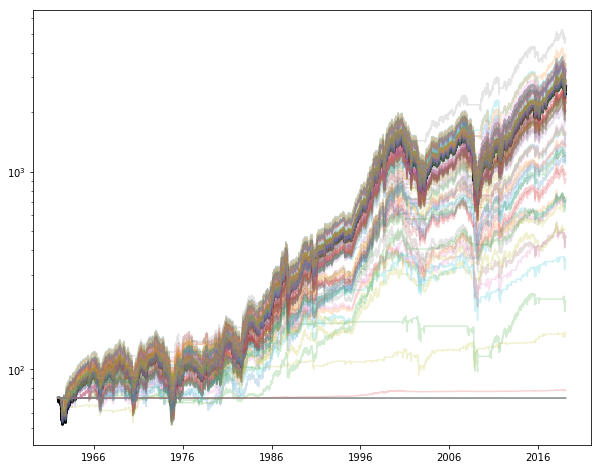

In [205]:
plt.figure(figsize=[10, 8])
plt.plot(sp.Date, sp.Value, 'k-', linewidth=3)
for i in range(ITERS):
    window_401k, params_401k = init_values(
        sd, best_window_401k, best_params_401k, min_window=60)
    sp = generate_actions(
        sp, window_401k, func=moving_dev_signals, params=params_401k)
    sp = predict_performance(sp)
    plt.plot(sp.Date, sp.Total, alpha=0.2);
    final_value_401k = sp.Total.tolist()[-1]
    print(f'{i + 1:2d}: Final value: ${final_value_401k:8.2f} '
          f'(window = {window_401k})')
    if final_value_401k > best_yet_401k:
        print(f'New best model!\n{params_401k}\nwindow: {window_401k}')
        best_yet_401k = final_value_401k
        best_params_401k = params_401k
plt.yscale('log');    